In [1]:
import mujoco
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------------
# Feedforward Pitch Oscillation Controller (with thrust)
# ---------------------------------------------------------
class FeedforwardPitchOscillation:
    """
    Purely feedforward controller commanding a sinusoidal pitch oscillation
    about the y-axis (nose up/down motion).

    Includes:
    - τ_y feedforward for rotation
    - f_z feedforward for maintaining altitude
    """

    def __init__(
        self,
        model,
        data,
        amp_deg: float = 45.0,
        n_oscillations: int = 5,
        tau_margin: float = 0.65, # changes trajectory
        period_scale: float = 5.0, # the higher, the slower
        torque_gain: float = 1.0, # scales control signal, does not impact frequency or trajectory
    ):
        self.model = model
        self.data = data
        self.torque_gain = torque_gain

        # Extract physical properties
        body_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "drone")
        self.mass = model.body_mass[body_id]
        self.Iyy = model.body_inertia[body_id][1]
        self.dt = float(model.opt.timestep)

        # Identify actuators (thrust + My torque)
        self.idx_thrust, self.idx_my = None, None
        for i in range(model.nu):
            gx, gy, gz, mx, my, mz = model.actuator_gear[i]
            if gz != 0 and self.idx_thrust is None:
                self.idx_thrust = i
            if my != 0 and self.idx_my is None:
                self.idx_my = i

        if self.idx_thrust is None or self.idx_my is None:
            raise RuntimeError("Thrust or My actuator not found in XML gear definitions.")

        # Motion parameters
        self.A = math.radians(amp_deg)
        self.tau_max = float(model.actuator_ctrlrange[self.idx_my, 1])
        self.omega = math.sqrt(tau_margin * self.tau_max / (self.Iyy * self.A)) / period_scale
        self.T_single = 2 * math.pi / self.omega
        self.T_total = n_oscillations * self.T_single

        # Gravity & hover thrust
        self.g = 9.81
        self.hover_thrust = self.mass * self.g

    def theta_des(self, t):
        return self.A * math.sin(self.omega * t) if t <= self.T_total else 0.0

    def theta_ddot_des(self, t):
        return -self.A * (self.omega ** 2) * math.sin(self.omega * t) if t <= self.T_total else 0.0

    def get_control(self, t):
        """Compute feedforward torque τ_y and thrust f_z."""
        theta_des = self.theta_des(t)
        theta_ddot_des = self.theta_ddot_des(t)

        # --- Feedforward torque ---
        tau_y = self.torque_gain * self.Iyy * theta_ddot_des
        tau_y = float(np.clip(tau_y, -self.tau_max, self.tau_max))

        # --- Feedforward thrust ---
        f_z = self.mass * self.g / max(np.cos(theta_des), 1e-3)
        f_z = np.clip(f_z, 0.0, self.mass * self.g * 2.0)

        # --- Control vector ---
        u = np.zeros(self.model.nu)
        u[self.idx_thrust] = f_z
        u[self.idx_my] = tau_y

        return u, tau_y, f_z




In [2]:
# ---------------------------------------------------------
# Run feedforward simulation
# ---------------------------------------------------------
model = mujoco.MjModel.from_xml_path("cf2_antal.xml")
data = mujoco.MjData(model)

ctrl = FeedforwardPitchOscillation(
    model,
    data,
    amp_deg=45.0,
    n_oscillations=2,
    tau_margin=0.25,
    period_scale=4.0,
    torque_gain=20.0,
)

t, t_list, theta_list, theta_des_list, tau_y_list, fz_list = 0.0, [], [], [], [], []

while t < ctrl.T_total + 0.5:
    u, tau_y, f_z = ctrl.get_control(t)
    data.ctrl[:] = u
    mujoco.mj_step(model, data)

    # Extract actual pitch from quaternion
    qw, qx, qy, qz = data.qpos[3:7]
    sin_theta = 2 * (qw * qy - qz * qx)
    theta = np.arcsin(np.clip(sin_theta, -1.0, 1.0))

    # Log data
    t_list.append(t)
    theta_list.append(np.degrees(theta))
    theta_des_list.append(np.degrees(ctrl.theta_des(t)))
    tau_y_list.append(tau_y)
    fz_list.append(f_z)

    t += model.opt.timestep


In [3]:
print("tau_max from model:", ctrl.tau_max)
print("tau_y min:", min(tau_y_list))
print("tau_y max:", max(tau_y_list))


tau_max from model: 0.007
tau_y min: -0.002187494509838169
tau_y max: 0.0021874977162676277


Pitch Tracking RMSE: 37.987 degrees


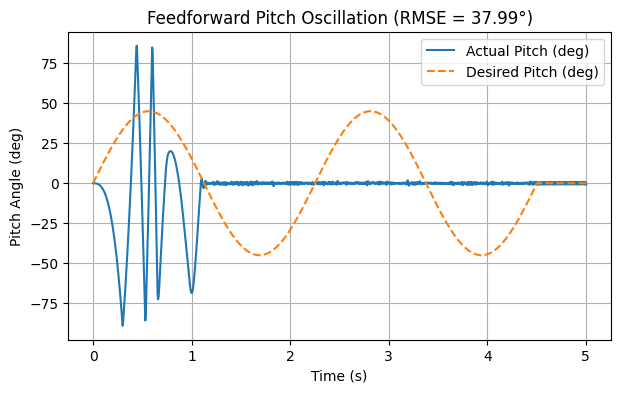

In [4]:
# ---------------------------------------------------------
# Compute RMSE
# ---------------------------------------------------------
theta_actual = np.array(theta_list)
theta_desired = np.array(theta_des_list)
rmse_deg = np.sqrt(np.mean((theta_actual - theta_desired) ** 2))

print(f"Pitch Tracking RMSE: {rmse_deg:.3f} degrees")

# ---------------------------------------------------------
# Plot results
# ---------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(t_list, theta_list, label="Actual Pitch (deg)")
plt.plot(t_list, theta_des_list, "--", label="Desired Pitch (deg)")
plt.xlabel("Time (s)")
plt.ylabel("Pitch Angle (deg)")
plt.title(f"Feedforward Pitch Oscillation (RMSE = {rmse_deg:.2f}°)")
plt.legend()
plt.grid(True)
plt.show()



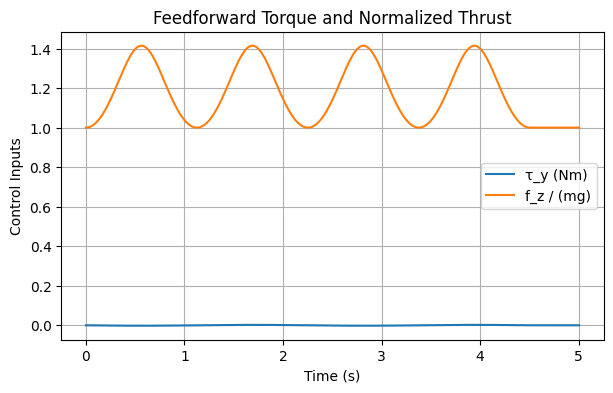

In [5]:
# ---------------------------------------------------------
# Plot τ_y and f_z
# ---------------------------------------------------------
plt.figure(figsize=(7, 4))
plt.plot(t_list, tau_y_list, label="τ_y (Nm)")
plt.plot(t_list, np.array(fz_list)/(ctrl.mass*ctrl.g), label="f_z / (mg)")
plt.xlabel("Time (s)")
plt.ylabel("Control Inputs")
plt.title("Feedforward Torque and Normalized Thrust")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# # ---------------------------------------------------------
# # Export torque & thrust data
# # ---------------------------------------------------------
# df = pd.DataFrame({
#     "t (s)": t_list,
#     "theta_des (deg)": theta_des_list,
#     "theta_actual (deg)": theta_list,
#     "tau_y (Nm)": tau_y_list,
#     "f_z (N)": fz_list
# })

# # df.to_csv("feedforward_pitch_torque_thrust.csv", index=False)
# # display(df.head(10))
# # print("Saved feedforward torque and thrust sequence to feedforward_pitch_torque_thrust.csv")

# print("\nC-style arrays (for embedded use):\n")
# print("float tau_y_ff[] = {")
# for tau in tau_y_list:
#     print(f"    {tau:.8f}f,")
# print("};\n")

# print("float f_z_ff[] = {")
# for f in fz_list:
#     print(f"    {f:.8f}f,")
# print("};")



C-style arrays (for embedded use):

float tau_y_ff[] = {
    -0.00000000f,
    -0.00003051f,
    -0.00006101f,
    -0.00009150f,
    -0.00012197f,
    -0.00015241f,
    -0.00018283f,
    -0.00021321f,
    -0.00024355f,
    -0.00027385f,
    -0.00030409f,
    -0.00033427f,
    -0.00036438f,
    -0.00039443f,
    -0.00042440f,
    -0.00045428f,
    -0.00048408f,
    -0.00051378f,
    -0.00054338f,
    -0.00057288f,
    -0.00060227f,
    -0.00063154f,
    -0.00066068f,
    -0.00068970f,
    -0.00071858f,
    -0.00074733f,
    -0.00077593f,
    -0.00080437f,
    -0.00083266f,
    -0.00086079f,
    -0.00088875f,
    -0.00091654f,
    -0.00094415f,
    -0.00097158f,
    -0.00099882f,
    -0.00102586f,
    -0.00105271f,
    -0.00107934f,
    -0.00110577f,
    -0.00113199f,
    -0.00115798f,
    -0.00118375f,
    -0.00120929f,
    -0.00123459f,
    -0.00125966f,
    -0.00128448f,
    -0.00130904f,
    -0.00133336f,
    -0.00135741f,
    -0.00138120f,
    -0.00140473f,
    -0.00142797f,
    -0

In [9]:
import numpy as np
import mujoco

def eval_rmse(tau_margin, period_scale, torque_gain,
              amp_deg=45.0,
              n_oscillations=2,
              tail_time=0.5,
              big_penalty=1e6):
    """
    Evaluate RMSE (deg) for given feedforward parameters.
    Purely feedforward: uses FeedforwardPitchOscillation as defined above.
    """

    # Basic sanity checks to avoid nonsense
    if tau_margin <= 0 or period_scale <= 0 or torque_gain <= 0:
        return big_penalty

    try:
        # fresh model & data every time
        model = mujoco.MjModel.from_xml_path("cf2_antal.xml")
        data = mujoco.MjData(model)

        ctrl = FeedforwardPitchOscillation(
            model,
            data,
            amp_deg=amp_deg,
            n_oscillations=n_oscillations,
            tau_margin=tau_margin,
            period_scale=period_scale,
            torque_gain=torque_gain,
        )

        t = 0.0
        t_list = []
        theta_act = []
        theta_des = []

        # simulate
        while t < ctrl.T_total + tail_time:
            u, tau_y, f_z = ctrl.get_control(t)
            data.ctrl[:] = u
            mujoco.mj_step(model, data)

            # actual pitch from quaternion
            qw, qx, qy, qz = data.qpos[3:7]
            sin_theta = 2.0 * (qw * qy - qz * qx)
            sin_theta = np.clip(sin_theta, -1.0, 1.0)
            theta = np.arcsin(sin_theta)

            t_list.append(t)
            theta_act.append(np.degrees(theta))
            theta_des.append(np.degrees(ctrl.theta_des(t)))

            t += model.opt.timestep

        t_arr = np.array(t_list)
        theta_act = np.array(theta_act)
        theta_des = np.array(theta_des)

        # focus RMSE on commanded interval only
        mask = t_arr <= ctrl.T_total
        if not np.any(mask):
            return big_penalty

        rmse = np.sqrt(np.mean((theta_act[mask] - theta_des[mask])**2))

        # NaNs / explosions guard
        if not np.isfinite(rmse):
            return big_penalty

        return rmse

    except Exception as e:
        print("Simulation error for",
              f"tau_margin={tau_margin}, period_scale={period_scale}, torque_gain={torque_gain}:",
              e)
        return big_penalty


In [10]:
from numpy.linalg import solve

def rbf_kernel(X1, X2, length_scale=0.5, sigma_f=1.0):
    """
    Squared exponential (RBF) kernel.
    X1: (N, d), X2: (M, d)
    """
    X1 = np.atleast_2d(X1)
    X2 = np.atleast_2d(X2)
    sqdist = np.sum((X1[:, None, :] - X2[None, :, :])**2, axis=2)
    return sigma_f**2 * np.exp(-0.5 / (length_scale**2) * sqdist)

def gp_posterior(X_train, y_train, X_test,
                 length_scale=0.5, sigma_f=1.0, sigma_n=1e-6):
    """
    Simple zero-mean GP regression.
    Returns posterior mean and std at X_test.
    """
    K = rbf_kernel(X_train, X_train, length_scale, sigma_f) + sigma_n**2 * np.eye(len(X_train))
    K_s = rbf_kernel(X_test, X_train, length_scale, sigma_f)
    K_ss = rbf_kernel(X_test, X_test, length_scale, sigma_f) + 1e-12 * np.eye(len(X_test))

    alpha = solve(K, y_train)
    mu_s = K_s @ alpha
    v = solve(K, K_s.T)
    cov_s = K_ss - K_s @ v
    std_s = np.sqrt(np.clip(np.diag(cov_s), 1e-12, np.inf))
    return mu_s, std_s

def expected_improvement(X_candidates, X_train, y_train,
                         length_scale=0.5, sigma_f=1.0, sigma_n=1e-6):
    """
    EI for MINIMIZATION.
    """
    from scipy.stats import norm

    mu, sigma = gp_posterior(X_train, y_train, X_candidates,
                             length_scale, sigma_f, sigma_n)
    y_best = np.min(y_train)

    with np.errstate(divide="ignore"):
        Z = (y_best - mu) / sigma
        ei = (y_best - mu) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei


SyntaxError: unterminated string literal (detected at line 62) (3589517290.py, line 62)

In [12]:
import numpy as np

# Search bounds
tau_bounds = (0.05, 0.9)       # tau_margin
period_bounds = (1.0, 8.0)     # period_scale
gain_bounds = (0.5, 40.0)      # torque_gain

n_init = 8        # initial random evaluations
n_iter = 25       # BO iterations
n_candidates = 300  # random candidates per EI step

X_train = []
y_train = []

rng = np.random.default_rng(42)

# ---- Initial random design ----
print("Initial random evaluations:")
for i in range(n_init):
    tau_m = rng.uniform(*tau_bounds)
    ps = rng.uniform(*period_bounds)
    g = rng.uniform(*gain_bounds)

    rmse = eval_rmse(tau_m, ps, g)
    X_train.append([tau_m, ps, g])
    y_train.append(rmse)
    print(f"  {i+1:02d}: tau_margin={tau_m:.3f}, period_scale={ps:.3f}, "
          f"torque_gain={g:.2f} -> RMSE={rmse:.2f}°")

X_train = np.array(X_train)
y_train = np.array(y_train)

# ---- BO loop ----
for it in range(n_iter):
    # Candidate set sampled uniformly in bounds
    cand_tau = rng.uniform(*tau_bounds, size=n_candidates)
    cand_ps = rng.uniform(*period_bounds, size=n_candidates)
    cand_g = rng.uniform(*gain_bounds, size=n_candidates)
    X_cand = np.column_stack([cand_tau, cand_ps, cand_g])

    # Compute EI (we minimize RMSE)
    ei = expected_improvement(
        X_cand,
        X_train,
        y_train,
        length_scale=0.5,  # you can tweak
        sigma_f=1.0,
        sigma_n=1e-3
    )

    # Pick best candidate
    idx_best = np.argmax(ei)
    x_next = X_cand[idx_best]

    tau_m, ps, g = x_next
    rmse = eval_rmse(tau_m, ps, g)

    # Augment dataset
    X_train = np.vstack([X_train, x_next])
    y_train = np.append(y_train, rmse)

    print(f"BO iter {it+1:02d}: tau_margin={tau_m:.3f}, period_scale={ps:.3f}, "
          f"torque_gain={g:.2f} -> RMSE={rmse:.2f}°")

# ---- Report best ----
best_idx = np.argmin(y_train)
best_tau, best_ps, best_g = X_train[best_idx]
best_rmse = y_train[best_idx]

print("\nBest parameters found:")
print(f"  tau_margin   = {best_tau:.4f}")
print(f"  period_scale = {best_ps:.4f}")
print(f"  torque_gain  = {best_g:.4f}")
print(f"  RMSE         = {best_rmse:.4f}°")


Initial random evaluations:
  01: tau_margin=0.708, period_scale=4.072, torque_gain=34.41 -> RMSE=43.13°
  02: tau_margin=0.643, period_scale=1.659, torque_gain=39.04 -> RMSE=68.40°
  03: tau_margin=0.697, period_scale=6.502, torque_gain=5.56 -> RMSE=53.68°
  04: tau_margin=0.433, period_scale=3.596, torque_gain=37.11 -> RMSE=38.35°
  05: tau_margin=0.597, period_scale=6.759, torque_gain=18.01 -> RMSE=44.15°
  06: tau_margin=0.243, period_scale=4.882, torque_gain=3.02 -> RMSE=47.24°
  07: tau_margin=0.753, period_scale=5.422, torque_gain=30.44 -> RMSE=45.54°
  08: tau_margin=0.351, period_scale=7.795, torque_gain=35.78 -> RMSE=35.63°
BO iter 01: tau_margin=0.181, period_scale=5.430, torque_gain=22.44 -> RMSE=41.52°
BO iter 02: tau_margin=0.675, period_scale=1.416, torque_gain=11.30 -> RMSE=49.06°
BO iter 03: tau_margin=0.833, period_scale=1.628, torque_gain=25.45 -> RMSE=77.41°
BO iter 04: tau_margin=0.078, period_scale=2.741, torque_gain=16.01 -> RMSE=37.60°
BO iter 05: tau_margin=0.2